#What is going on in just one city?

So, I had to change the direction of my analysis. <br>
Census data, encompassing all variables I deem useful, does not have enough resolution to answer truly which exact location would be suitable for which type of the business. Thus, I decided to continue my research using only Yelp data. This means that the whole approach to the problem is slightly changed. <br><br>
Instead, I will analyse only one city and see what exactly is going on in groups of business across the whole city. <br>
To accomplish that I need data from one whole city. Yelp is offering complete data just for few cities. One of them is Phoenix, AZ. A quite big sprawling city that is car orientated. So let us see what is going on in this city. 

Let us get data. 

In [1]:
#general
import numpy as np
import scipy
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import MySQLdb
import os
import sys
sys.setrecursionlimit(3000)

Populating the interactive namespace from numpy and matplotlib


In [3]:
con=MySQLdb.connect(user=user, passwd=passwd, db=dbname, host=host)
df = pd.read_sql("SELECT * FROM business WHERE state ='AZ' ", con)
print "data loaded"

data loaded


Time to apply clustering algorithm. <br>
In the separate notebook, I explained why I think DBSCAN is the best choice for the geographic application. Especially when this algorithm is compared with K-means. <br>
So, let us start. 

In [8]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
coordinates = df2.as_matrix(columns=['longitude', 'latitude'])


I choose to set the maximum distance to approximately half a mile. Since, in this case, distance is measured in degrees of latitude and longitude, an exact number is 0.006. <br>
Although it is not recommended to put one as minimum samples, I decided to make it so because there might be locations that could support additional business.  

In [11]:
db = DBSCAN(eps=.006, min_samples=1).fit(coordinates)
labels = db.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)


Number of clusters: 1040


I got 1040 clusters. Not surprising, considering the size of Phoenix. 

Let us plot it. 

First, calculations of the centroids. If the cluster has less than 3 points, instead of calculation of the centroid, I will just take first location as a centroid. It is a waste of computer resources to calculate centroid in that case.   

In [14]:
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

In [15]:
def getNearestPoint(set_of_points, point_of_reference):
    closest_point = None
    closest_dist = None
    for point in set_of_points:
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    return closest_point

In [16]:
lon = []
lat = []
for i, cluster in clusters.iteritems():
    if len(cluster) < 3:
        representative_point = (cluster[0][1], cluster[0][0])
    else:
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    lon.append(representative_point[0])
    lat.append(representative_point[1])
rs = pd.DataFrame({'lon':lon, 'lat':lat})

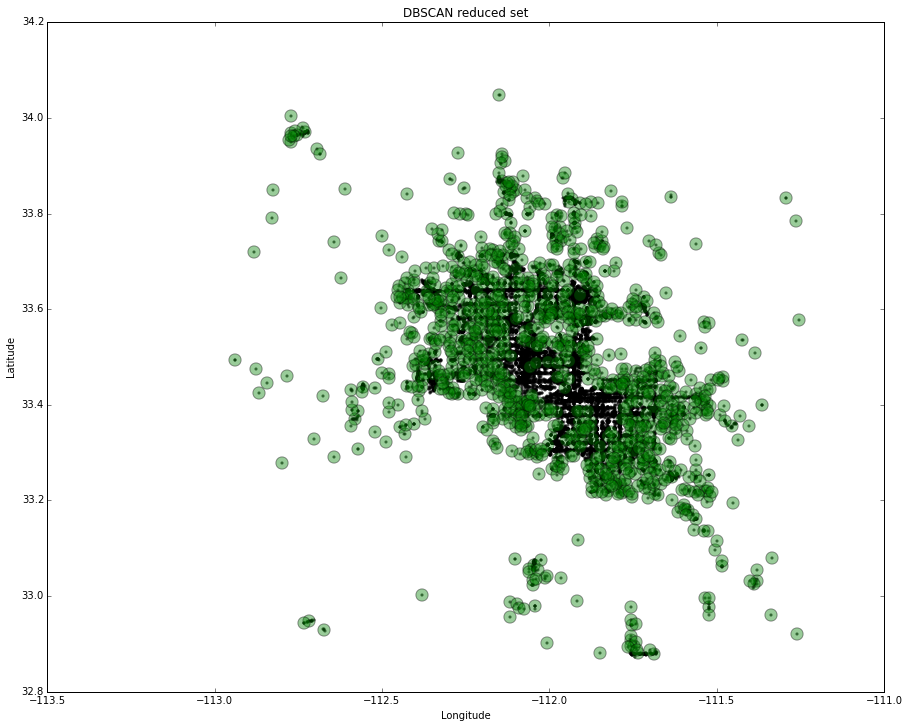

In [17]:
plt.figure(figsize=(15, 12), dpi=100)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.5, s=5)
rs_scatter = plt.scatter(rs['lat'], rs['lon'], c='g', alpha=.4, s=150)
plt.title( 'DBSCAN reduced set')
#plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.xlim(rs.lon.min(),rs.lon.max())
#plt.ylim(rs.lat.min(),rs.lat.max())
plt.show()

It seems that downtown areas need to be analysed separately. I got massive clusters along the main shopping arteries of the city. 

In [23]:
lats      = rs.lat.tolist()
lons      = rs.lon.tolist()
meanlat=rs.lat.mean()
meanlong=rs.lon.mean()

However, let us show this on a map. I decided to use Folium package for this purpose. 

In [21]:
from IPython.display import HTML
import folium
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 310px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))


In [22]:
meanlat=rs.lat.mean()
meanlong=rs.lon.mean()
map = folium.Map(width=600,height=600,location=[meanlong,meanlat])

for i in range(len(lats)):
    map.simple_marker([lons[i], lats[i]],marker_color='green',marker_icon='ok-sign', popup=str(i))
    


inline_map(map)